In [1]:
# Install the packages needed
!pip install pmdarima statsmodels scikit-learn

Defaulting to user installation because normal site-packages is not writeable


In [2]:
# Import the libraries needed

import math
import warnings
import os
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8-whitegrid")  

# modelling libraries needed
try:
    import pmdarima as pm
    from statsmodels.tsa.arima.model import ARIMA
    from statsmodels.tsa.holtwinters import ExponentialSmoothing
    from statsmodels.tsa.stattools import adfuller
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
except Exception as e:
    raise RuntimeError("Missing modeling packages. Install pmdarima, statsmodels, scikit-learn.") from e

In [5]:
# --------------------- 1. USER SETTINGS ---------------------
CONN_STR = (
    "DRIVER={ODBC Driver 17 for SQL Server};"
    "SERVER=10.10.39.10;"
    "DATABASE=;"
    "Trusted_Connection=yes;"
)

# SQL Queries
QUERY_WITHDRAWALS = """
SELECT
    [business_date],
    [terminal_id],
    [short_name],
    [sink_node_name],
    [fin_impact],
    [amount],
    [count],
    [tran_type]
FROM [Archive_PCI].[REPORTS].[VW_BWATMS_withdrawal_transaction_summary]
WHERE business_date >= '2020-01-01'
  AND business_date <= '2025-11-30'
ORDER BY terminal_id, business_date
"""

QUERY_DOWNTIME = """
SELECT
    [event_nr],
    [terminal_id],
    [short_name],
    [out_off_service_time],
    [into_service_time],
    [mode]
FROM [Archive_PCI].[REPORTS].[VW_BWATMS_Downtime_Events]
WHERE out_off_service_time >= '2020-01-01'
  AND out_off_service_time <= '2025-11-30'
ORDER BY terminal_id, out_off_service_time
"""

OUT_PATH = Path(r"M:\Credit Risk\CRF Data Analysis\Silvia Prep\ATM Modelling")
OUT_PATH.mkdir(parents=True, exist_ok=True)
charts_dir = OUT_PATH / "charts"
charts_dir.mkdir(exist_ok=True)
results_dir = OUT_PATH / "results"
results_dir.mkdir(exist_ok=True)
featimp_dir = results_dir / "feature_importances"
featimp_dir.mkdir(exist_ok=True)

HOLIDAY_XLSX = Path(r"M:\Credit Risk\CRF Data Analysis\Silvia Prep\ATM Modelling\Public Holidays - Namibia.xlsx")
ATM_LOCATION_XLSX = Path(r"M:\Credit Risk\CRF Data Analysis\Silvia Prep\ATM Modelling\ATM_LOCATION.xlsx")

# modelling parameters set
# skip ATMs with fewer days than 90
MIN_DAYS_PER_ATM = 90  
# number of lag days for RF
LAGS = 7                     
RF_N_ESTIMATORS = 200
# sample for RF importance
RF_SAMPLE_MAX = 20000   

In [7]:
# --------------------- 2. EXTRACT FROM SQL ---------------------
import pyodbc
print("Step 2: extracting data from SQL...")
with pyodbc.connect(CONN_STR) as conn:
    df_withdrawals = pd.read_sql(QUERY_WITHDRAWALS, conn)
    df_downtime = pd.read_sql(QUERY_DOWNTIME, conn)

print("Withdrawals rows:", len(df_withdrawals), " Downtime rows:", len(df_downtime))

Step 2: extracting data from SQL...
Withdrawals rows: 2055151  Downtime rows: 2051304


In [8]:
# ------------------- 3. Functions that will help with the models --------------------
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero_idx = y_true != 0
    if np.any(nonzero_idx):
        return np.mean(np.abs((y_true[nonzero_idx] - y_pred[nonzero_idx]) / y_true[nonzero_idx])) * 100
    else:
        return np.nan

def check_stationarity(series):
    result = adfuller(series.dropna())
    return result[1] < 0.05  

def has_seasonality(series, period=7):
    # Simple check: autocorrelation at lag=period
    return series.autocorr(lag=period) > 0.3

def prepare_lag_features(df, lag_count):
    df = df.sort_values(['terminal_id', 'date'])
    for lag in range(1, lag_count + 1):
        df[f'lag_{lag}'] = df.groupby('terminal_id')['total_withdrawals'].shift(lag)
    return df

def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return mae, rmse, mape

In [9]:
#-----------------------4. Looking at the structure of the tables and how the data looks ----------
print("Withdrawals data (top 5 rows):")
df_withdrawals.head()
df_downtime = pd.read_sql(QUERY_DOWNTIME, conn)

print("Downtime data (top 5 rows):")
df_downtime.head()
atm_loc_df = pd.read_excel(ATM_LOCATION_XLSX, engine='openpyxl')

print("ATM Location data (top 5 rows):")
atm_loc_df.head()

# Extract Holiday excel document
HOLIDAY_XLSX = Path(r"M:\Credit Risk\CRF Data Analysis\Silvia Prep\Master Thesis\Public Holidays - Namibia.xlsx")

if HOLIDAY_XLSX.exists():
    hol_df = pd.read_excel(HOLIDAY_XLSX, sheet_name=0, engine='openpyxl', index_col=0)
    print("Raw holiday data (top 5 rows):")
    display(hol_df.head())  # shows the first 5 rows
else:
    print("Holiday Excel not found.")

Withdrawals data (top 5 rows):
Downtime data (top 5 rows):
ATM Location data (top 5 rows):
Raw holiday data (top 5 rows):


,Year,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
NaN,2020,2021,2022,2023,2024,2025
New Year's Day,2020-01-01 00:00:00,2021-01-01 00:00:00,2022-01-01 00:00:00,2023-01-01 00:00:00,2024-01-01 00:00:00,2025-01-01 00:00:00
Public Holiday (For public servants),NaN,NaN,NaN,NaN,2024-02-26 00:00:00,NaN
Independence Day,2020-03-21 00:00:00,2021-03-21 00:00:00,2022-03-21 00:00:00,2023-03-21 00:00:00,2024-03-21 00:00:00,2025-03-21 00:00:00
Good Friday,2020-04-10 00:00:00,2021-04-02 00:00:00,2022-04-15 00:00:00,2023-04-07 00:00:00,2024-03-29 00:00:00,2025-04-18 00:00:00


In [10]:
if HOLIDAY_XLSX.exists():
    hol_raw = pd.read_excel(HOLIDAY_XLSX, sheet_name=0, engine='openpyxl', index_col=0)
    # Melt so each date is a row
    hol_raw.columns = [str(c).strip() for c in hol_raw.columns]  # clean column names
    hol_melt = hol_raw.reset_index().melt(id_vars='index', var_name='year', value_name='date')
    hol_melt.rename(columns={'index':'holiday_name'}, inplace=True)
    hol_melt = hol_melt.dropna(subset=['date'])  # remove NaNs
    hol_melt['date'] = pd.to_datetime(hol_melt['date'], errors='coerce')
    hol_melt = hol_melt.dropna(subset=['date'])
    holiday_dates = hol_melt['date'].dt.normalize().dt.date.tolist()

    # Check the first 5 holidays
    print("Parsed holiday dates (top 5):")
    print(holiday_dates[:5])
else:
    print("Holiday Excel not found.")
    holiday_dates = []

Parsed holiday dates (top 5):
[datetime.date(1970, 1, 1), datetime.date(2020, 1, 1), datetime.date(2020, 3, 21), datetime.date(2020, 4, 10), datetime.date(2020, 4, 12)]


In [15]:
# Filter valid dates only
holiday_dates = pd.to_datetime(hol_melt['date'], errors='coerce')  # coerce errors
# remove time, convert to date
holiday_dates = holiday_dates.dropna().dt.normalize().dt.date  
holiday_dates = [d for d in holiday_dates if d.year >= 2000]

print("Parsed holiday dates (top 5):")
print(holiday_dates[:5])

Parsed holiday dates (top 5):
[datetime.date(2020, 1, 1), datetime.date(2020, 3, 21), datetime.date(2020, 4, 10), datetime.date(2020, 4, 12), datetime.date(2020, 4, 13)]


In [17]:
# --------------------- 5. DATA CLEANING ---------------------
print("Step 5: Data cleaning...")

# standardize column names to lower-case (easier to reference)
df_withdrawals.columns = [c.strip().lower() for c in df_withdrawals.columns]
df_downtime.columns = [c.strip().lower() for c in df_downtime.columns]

# drop duplicate rows
df_withdrawals = df_withdrawals.drop_duplicates()
df_downtime = df_downtime.drop_duplicates()

# convert datetime columns
df_withdrawals['business_date'] = pd.to_datetime(df_withdrawals['business_date'], errors='coerce')
df_downtime['out_off_service_time'] = pd.to_datetime(df_downtime['out_off_service_time'], errors='coerce')
df_downtime['into_service_time'] = pd.to_datetime(df_downtime['into_service_time'], errors='coerce')

# coerce numeric withdrawals/count
df_withdrawals['amount'] = pd.to_numeric(df_withdrawals['amount'], errors='coerce').fillna(0)
# 'count' might be named 'count' or 'no_of_transactions' — handle both if present
if 'count' in df_withdrawals.columns:
    df_withdrawals['count'] = pd.to_numeric(df_withdrawals['count'], errors='coerce').fillna(0)
elif 'no_of_transactions' in df_withdrawals.columns:
    df_withdrawals['count'] = pd.to_numeric(df_withdrawals['no_of_transactions'], errors='coerce').fillna(0)
else:
    df_withdrawals['count'] = 0

# downtime minutes
df_downtime['downtime_minutes'] = (df_downtime['into_service_time'] - df_downtime['out_off_service_time']).dt.total_seconds()/60
df_downtime['downtime_minutes'] = df_downtime['downtime_minutes'].fillna(0)

Step 5: Data cleaning...


In [18]:
# --------------------- 6. AGGREGATE DAILY PER ATM ---------------------
print("Step 6: aggregate to daily per ATM...")

# withdrawals aggregated daily
df_withdrawals_daily = (
    df_withdrawals
    .groupby(['business_date','terminal_id'], dropna=False)
    .agg(total_withdrawals=('amount','sum'),
         total_transactions=('count','sum'))
    .reset_index()
    .rename(columns={'business_date':'date'})
)

# downtime aggregated per day per ATM (use out_off_service_time date)
df_downtime_daily = (
    df_downtime
    .assign(date=lambda x: x['out_off_service_time'].dt.floor('D'))
    .groupby(['date','terminal_id'], dropna=False)
    .agg(downtime_minutes=('downtime_minutes','sum'))
    .reset_index()
)

# unify date types
df_withdrawals_daily['date'] = pd.to_datetime(df_withdrawals_daily['date'])
df_downtime_daily['date'] = pd.to_datetime(df_downtime_daily['date'])

# merge
df_daily = pd.merge(df_withdrawals_daily, df_downtime_daily, on=['date','terminal_id'], how='left')
df_daily['downtime_minutes'] = df_daily['downtime_minutes'].fillna(0)

Step 6: aggregate to daily per ATM...


In [20]:
# ----------------- 7. Defining the path where the results, charts, are getting saved--------------

save_path = r"M:\Credit Risk\CRF Data Analysis\Silvia Prep\ATM Modelling"

# Creating a boxplot for all ATM withdrawals
plt.figure(figsize=(10, 5))
df_daily.boxplot(column='total_withdrawals')
plt.title('Boxplot of ATM Withdrawals (All ATMs)')
plt.ylabel('Withdrawal Amount (N$)')
plt.grid(True, linestyle='--', alpha=0.7)

# Save to file
output_file = os.path.join(save_path, "Figure_Boxplot_ATM_Withdrawals.png")
plt.tight_layout()
plt.savefig(output_file, dpi=300)
plt.close()

print(f"Boxplot saved successfully to: {output_file}")

Boxplot saved successfully to: M:\Credit Risk\CRF Data Analysis\Silvia Prep\ATM Modelling\Figure_Boxplot_ATM_Withdrawals.png


In [23]:
# --------------------- 8. LOAD & MAP ATM LOCATION (Terminal_ID) ---------------------
print("Step 8: load ATM location mapping and merge...")

if ATM_LOCATION_XLSX.exists():
    atm_loc_df = pd.read_excel(ATM_LOCATION_XLSX, engine='openpyxl')
    # standardize column names
    atm_loc_df.columns = [c.strip() for c in atm_loc_df.columns]
    # keep only rows that have Terminal_ID (others are towns without ATMs)
    if 'Terminal_ID' in atm_loc_df.columns:
        atm_loc_valid = atm_loc_df.dropna(subset=['Terminal_ID']).copy()
    elif 'terminal_id' in [c.lower() for c in atm_loc_df.columns]:
        # try lowercase name
        atm_loc_df.columns = [c.lower() for c in atm_loc_df.columns]
        atm_loc_valid = atm_loc_df.dropna(subset=['terminal_id']).copy()
        atm_loc_valid.rename(columns={'terminal_id':'Terminal_ID'}, inplace=True)
    else:
        raise ValueError("ATM location file must have a 'Terminal_ID' column.")

    # Normalize the keys and target columns
    # Accept many possible column names; attempt best-effort mapping:
    col_map = {cn.lower():cn for cn in atm_loc_valid.columns}
    # find town, region, rural/urban and terminal id column names (case-insensitive)
    terminal_col = next((c for c in atm_loc_valid.columns if c.lower().replace(" ", "") in ['terminalid','terminal_id']), None)
    town_col = next((c for c in atm_loc_valid.columns if 'town' in c.lower()), None)
    region_col = next((c for c in atm_loc_valid.columns if 'region' in c.lower()), None)
    ru_col = next((c for c in atm_loc_valid.columns if 'rural' in c.lower() or 'urban' in c.lower() or 'rural / urban' in c.lower()), None)

    # Ensure terminal_col exists
    if terminal_col is None:
        raise ValueError("Could not find Terminal_ID column in location file.")

    # Build mapping dicts using terminal id
    atm_loc_valid[terminal_col] = atm_loc_valid[terminal_col].astype(str).str.strip()
    town_dict = {str(k).strip(): (str(v).strip() if pd.notna(v) else "Unknown") for k,v in zip(atm_loc_valid[terminal_col], atm_loc_valid[town_col])} if town_col else {}
    region_dict = {str(k).strip(): (str(v).strip() if pd.notna(v) else "Unknown") for k,v in zip(atm_loc_valid[terminal_col], atm_loc_valid[region_col])} if region_col else {}
    ru_dict = {str(k).strip(): (str(v).strip() if pd.notna(v) else "Unknown") for k,v in zip(atm_loc_valid[terminal_col], atm_loc_valid[ru_col])} if ru_col else {}

    # Map onto df_daily (terminal_id might be numeric or string, normalize both)
    df_daily['terminal_id'] = df_daily['terminal_id'].astype(str).str.strip()
    df_daily['ATM_Town'] = df_daily['terminal_id'].map(town_dict).fillna('Unknown')
    df_daily['Region'] = df_daily['terminal_id'].map(region_dict).fillna('Unknown')
    df_daily['ATM_Location_Type'] = df_daily['terminal_id'].map(ru_dict).fillna('Unknown')  # Rural/Urban
else:
    print("ATM location file not found - ATM_Town/Region/Location_Type will be 'Unknown'")
    df_daily['ATM_Town'] = 'Unknown'
    df_daily['Region'] = 'Unknown'
    df_daily['ATM_Location_Type'] = 'Unknown'

Step 8: load ATM location mapping and merge...


In [25]:
# --------------------- 9. LOAD & PARSE HOLIDAYS ---------------------
print("Step 9: load and parse public holidays...")
holiday_dates = []
if HOLIDAY_XLSX.exists():
    try:
        hol_raw = pd.read_excel(HOLIDAY_XLSX, sheet_name=0, engine='openpyxl', index_col=0)
        # Try robust parsing: melt wide year columns or detect a single date column
        hol_raw.columns = [str(c).replace('Year ','').strip() for c in hol_raw.columns]
        hol_melt = hol_raw.reset_index().melt(id_vars='index', var_name='year', value_name='date')
        hol_melt.rename(columns={'index':'holiday_name'}, inplace=True)
        hol_melt = hol_melt.dropna(subset=['date'])
        hol_melt['date'] = pd.to_datetime(hol_melt['date'], errors='coerce', dayfirst=True)
        hol_melt = hol_melt.dropna(subset=['date'])
        holiday_dates = list(pd.to_datetime(hol_melt['date']).dt.normalize().dt.date.unique())
    except Exception as e:
        print("Could not parse holiday file, holiday list will be empty. Error:", e)
        holiday_dates = []
else:
    print("Holiday excel not found - no holidays will be flagged.")

df_daily['is_holiday'] = df_daily['date'].dt.date.isin(holiday_dates).astype(int)

Step 9: load and parse public holidays...


In [27]:
# --------------------- 10. TIME FEATURES & PAYDAY ---------------------
print("Step 10: add time features and paydays...")
df_daily['day_of_week'] = df_daily['date'].dt.dayofweek  
df_daily['month'] = df_daily['date'].dt.month
df_daily['year'] = df_daily['date'].dt.year
df_daily['day'] = df_daily['date'].dt.day
df_daily['is_month_end'] = df_daily['date'].dt.is_month_end.astype(int)
PAY_DAYS = [15,20,25,30,31]
df_daily['is_payday'] = df_daily['day'].isin(PAY_DAYS).astype(int)

Step 10: add time features and paydays...


In [29]:
# --------------------- 11. LAG FEATURES ---------------------
print(f"Step 11: create {LAGS} lag features (needed for RF)...")
df_daily = df_daily.sort_values(['terminal_id','date'])
for lag in range(1, LAGS+1):
    df_daily[f'lag_{lag}'] = df_daily.groupby('terminal_id')['total_withdrawals'].shift(lag)

Step 11: create 7 lag features (needed for RF)...


In [31]:
# --------------------- 12. SAVE CLEANED DAILY (pre-model) ---------------------
clean_csv = OUT_PATH / "df_daily_cleaned_pre_model.csv"
df_daily.to_csv(clean_csv, index=False)
print("Saved cleaned daily data (pre-model) to:", clean_csv)

Saved cleaned daily data (pre-model) to: M:\Credit Risk\CRF Data Analysis\Silvia Prep\ATM Modelling\df_daily_cleaned_pre_model.csv


In [32]:
#------------------------13 Load the cleaned data-------------------------------------
df_daily = pd.read_csv(clean_csv, parse_dates=['date'])
print(df_daily.head())

        date terminal_id  total_withdrawals  total_transactions  \
0 2025-06-07    BWATM100           216060.0                 368   
1 2025-06-08    BWATM100           108970.0                 288   
2 2025-06-09    BWATM100           145040.0                 227   
3 2025-06-10    BWATM100            60560.0                  64   
4 2025-06-11    BWATM100           154380.0                 337   

   downtime_minutes ATM_Town     Region ATM_Location_Type  is_holiday  \
0         51.278833  Eenhana  Ohangwena             Urban           0   
1          0.179167  Eenhana  Ohangwena             Urban           0   
2         70.682567  Eenhana  Ohangwena             Urban           0   
3         13.782267  Eenhana  Ohangwena             Urban           0   
4         65.476833  Eenhana  Ohangwena             Urban           0   

   day_of_week  ...  day  is_month_end  is_payday     lag_1     lag_2  \
0            5  ...    7             0          0       NaN       NaN   
1           

In [35]:
#-----------------------------14 Feature Engineering ------------------------------- 
df_daily = prepare_lag_features(df_daily, LAGS)
df_daily.fillna(0, inplace=True)

In [37]:
#-----------------------------15 Model-Specific Data Preparation------------------------
print("Step 15: prepare ARIMA, RF and HW datasets (model-specific cleaning)...")

# --------------------- ARIMA dataset ---------------------
df_arima = df_daily.copy()
df_arima['total_withdrawals'] = df_arima.groupby('terminal_id')['total_withdrawals'] \
                                        .transform(lambda s: s.fillna(method='ffill').fillna(0)) 
for lag in range(1, LAGS+1):
    col = f'lag_{lag}'
    if col in df_arima.columns:
        df_arima[col] = df_arima.groupby('terminal_id')[col] \
                                .transform(lambda s: s.fillna(method='ffill').fillna(0)) 

# --------------------- Random Forest dataset ---------------------
df_rf = df_daily.copy()
num_cols = ['total_withdrawals','total_transactions','downtime_minutes'] + [f'lag_{i}' for i in range(1, LAGS+1)]
for c in num_cols:
    if c in df_rf.columns:
        median_val = df_rf[c].median()
        df_rf[c] = pd.to_numeric(df_rf[c], errors='coerce').fillna(median_val)
cat_cols = ['ATM_Location_Type','Region','ATM_Town']
for c in cat_cols:
    if c in df_rf.columns:
        try:
            mode_val = df_rf[c].mode(dropna=True)[0]
        except Exception:
            mode_val = 'Unknown'
        df_rf[c] = df_rf[c].fillna(mode_val)

# --------------------- Holt-Winters dataset ---------------------
df_hw = df_daily.copy()
df_hw['total_withdrawals'] = df_hw.groupby('terminal_id')['total_withdrawals'] \
                                 .transform(lambda s: s.fillna(method='ffill').fillna(0)) 

Step 15: prepare ARIMA, RF and HW datasets (model-specific cleaning)...


In [39]:
# ------------------- TABLE 1: ADF Test -------------------
from pathlib import Path
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Output path
OUT_PATH = Path(r"M:\Credit Risk\CRF Data Analysis\Silvia Prep\ATM Modelling")

# Run ADF test
adf_results = []
for atm in df_daily['terminal_id'].unique():
    series = df_daily[df_daily['terminal_id'] == atm]['total_withdrawals'].dropna()
    result = adfuller(series)
    adf_results.append([atm, result[0], result[1]])  # test statistic, p-value

# Save results
pd.DataFrame(adf_results, columns=['ATM_ID', 'ADF_Stat', 'p-value']).to_excel(OUT_PATH / 'Table_1_ADF_Test.xlsx', index=False)

In [41]:
# -----------------TABLE 2: Fixing ADF Stationarity ----------------------------

# Loading the original ADF test results
adf_table = pd.read_excel(r"M:\Credit Risk\CRF Data Analysis\Silvia Prep\ATM Modelling\Table_1_ADF_Test.xlsx")

# Identify non-stationary ATMs (p-value > 0.05)
non_stationary_atms = adf_table[adf_table['p-value'] > 0.05]['ATM_ID'].tolist()

# Run ADF test on differenced series for non-stationary ATMs
adf_diff_results = []
for atm in non_stationary_atms:
    # Select the time series for this ATM
    series = df_daily[df_daily['terminal_id'] == atm]['total_withdrawals'].dropna()
    # First difference
    differenced_series = series.diff().dropna()
    # ADF test on differenced series
    result = adfuller(differenced_series)
    adf_diff_results.append([atm, result[0], result[1]])  # test statistic, p-value

# Save the results to a new Excel file in the specified path
adf_diff_df = pd.DataFrame(adf_diff_results, columns=['ATM_ID', 'ADF_Stat', 'p-value'])
adf_diff_df.to_excel(r"M:\Credit Risk\CRF Data Analysis\Silvia Prep\ATM Modelling\Table_2_ADF_Test_Differenced.xlsx", index=False)

In [43]:
# --------------------- 16. MODELLING: per-ATM ARIMA, Holt-Winters & RF ---------------------
print("Step 16: per-ATM modeling (ARIMA, Holt-Winters, and Random Forest)")

# Helper function for MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero_idx = y_true != 0
    if np.any(nonzero_idx):
        return np.mean(np.abs((y_true[nonzero_idx] - y_pred[nonzero_idx]) / y_true[nonzero_idx])) * 100
    else:
        return np.nan

atm_ids = sorted(df_daily['terminal_id'].dropna().unique().tolist())
print("ATMs to model:", len(atm_ids))

results = []
charts_dir.mkdir(exist_ok=True)
featimp_dir = results_dir / "feature_importances"
featimp_dir.mkdir(exist_ok=True)

for atm in atm_ids:
    try:
        atm_str = str(atm)
        # Prepare per-ATM data
        at_ar = df_arima[df_arima['terminal_id']==atm_str].sort_values('date').reset_index(drop=True)
        at_rf = df_rf[df_rf['terminal_id']==atm_str].sort_values('date').reset_index(drop=True)

        # Ensure continuous dates for ARIMA/Holt-Winters
        if len(at_ar)==0:
            continue
        start = at_ar['date'].min()
        end = at_ar['date'].max()
        date_idx = pd.date_range(start=start, end=end, freq='D')
        at_ar = at_ar.set_index('date').reindex(date_idx).rename_axis('date').reset_index()
        at_ar['terminal_id'] = atm_str

        # Fill static fields
        for col in ['ATM_Town','Region','ATM_Location_Type','is_holiday','is_payday','day_of_week']:
            if col in at_ar.columns:
                at_ar[col] = at_ar[col].fillna(method='ffill').fillna(method='bfill')

        # Fill withdrawals and recompute lags
        at_ar['total_withdrawals'] = at_ar['total_withdrawals'].fillna(method='ffill').fillna(0)
        for lag in range(1, LAGS+1):
            at_ar[f'lag_{lag}'] = at_ar['total_withdrawals'].shift(lag).fillna(0)

        n = len(at_ar)
        if n < MIN_DAYS_PER_ATM:
            results.append({
                'ATM_ID': atm_str, 'N_days': n,
                'ARIMA_order': None,
                'ARIMA_MAE': np.nan, 'ARIMA_RMSE': np.nan, 'ARIMA_MAPE': np.nan,
                'HW_MAE': np.nan, 'HW_RMSE': np.nan, 'HW_MAPE': np.nan,
                'RF_MAE': np.nan, 'RF_RMSE': np.nan, 'RF_MAPE': np.nan,
                'Best_Model': None
            })
            continue

        split_idx = int(n * 0.8)
        train_ar = at_ar.iloc[:split_idx]
        test_ar = at_ar.iloc[split_idx:]

        # ---------- ARIMA ----------
        try:
            auto = pm.auto_arima(train_ar['total_withdrawals'],
                                 seasonal=False, stepwise=True,
                                 suppress_warnings=True, error_action='ignore',
                                 max_p=5, max_q=5, max_order=None)
            order = auto.order
            model = ARIMA(train_ar['total_withdrawals'], order=order)
            fit = model.fit()
            arima_forecast = fit.forecast(steps=len(test_ar))
            arima_mae = mean_absolute_error(test_ar['total_withdrawals'], arima_forecast)
            arima_rmse = math.sqrt(mean_squared_error(test_ar['total_withdrawals'], arima_forecast))
            arima_mape = mean_absolute_percentage_error(test_ar['total_withdrawals'], arima_forecast)
        except Exception:
            order = None
            arima_forecast = pd.Series([np.nan]*len(test_ar), index=test_ar.index)
            arima_mae = arima_rmse = arima_mape = np.nan
            
                  # Save ARIMA chart
        try:
            plt.figure(figsize=(8,3))
            plt.plot(train_ar['date'], train_ar['total_withdrawals'], label='train', color='black', alpha=0.6)
            plt.plot(test_ar['date'], test_ar['total_withdrawals'], label='test', color='gray', alpha=0.6)
            plt.plot(test_ar['date'], arima_forecast, label='ARIMA forecast', color='blue')
            plt.title(f'ATM {atm_str} ARIMA forecast (order={order})')
            plt.xlabel('Date')
            plt.ylabel('Total withdrawals (N$)')
            plt.legend()
            plt.tight_layout()
            plt.savefig(charts_dir / f"arima_{atm_str}.png")
            plt.close()
        except Exception:
            pass

        # ---------- HOLT-WINTERS ----------
        from statsmodels.tsa.holtwinters import ExponentialSmoothing
        try:
            seasonal = train_ar['total_withdrawals'].autocorr(lag=7) > 0.3
            hw_model = ExponentialSmoothing(
                train_ar['total_withdrawals'],
                trend='add',
                seasonal='add' if seasonal else None,
                seasonal_periods=7 if seasonal else None
            ).fit()
            hw_forecast = hw_model.forecast(steps=len(test_ar))
            hw_mae = mean_absolute_error(test_ar['total_withdrawals'], hw_forecast)
            hw_rmse = math.sqrt(mean_squared_error(test_ar['total_withdrawals'], hw_forecast))
            hw_mape = mean_absolute_percentage_error(test_ar['total_withdrawals'], hw_forecast)
        except Exception:
            hw_forecast = pd.Series([np.nan]*len(test_ar), index=test_ar.index)
            hw_mae = hw_rmse = hw_mape = np.nan
            
              
                      # Save Holt-Winters chart
        
        if not np.isnan(hw_forecast).all():
            plt.figure(figsize=(8,3))
            plt.plot(train_ar['date'], train_ar['total_withdrawals'], label='Train', color='black')
            plt.plot(test_ar['date'], test_ar['total_withdrawals'], label='Test', color='gray')
            plt.plot(test_ar['date'], hw_forecast, label='Holt-Winters Forecast', color='green')
            plt.title(f'ATM {atm_str} - Holt-Winters')
            plt.xlabel('Date')
            plt.ylabel('Total withdrawals (N$)')
            plt.legend(); plt.tight_layout()
            plt.savefig(charts_dir / f"holtwinters_{atm_str}.png"); plt.close()


        # ---------- RANDOM FOREST ----------
        at_rf = at_rf.set_index('date').reindex(pd.date_range(start=start, end=end, freq='D')).rename_axis('date').reset_index()
        at_rf['terminal_id'] = atm_str
        for lag in range(1, LAGS+1):
            col = f'lag_{lag}'
            if col not in at_rf.columns:
                at_rf[col] = at_rf['total_withdrawals'].shift(lag)
            at_rf[col] = pd.to_numeric(at_rf[col], errors='coerce').fillna(at_rf[col].median() if at_rf[col].notna().any() else 0)

        features = [f'lag_{i}' for i in range(1, LAGS+1)] + ['downtime_minutes','is_holiday','is_payday','day_of_week']
        if 'ATM_Location_Type' in at_rf.columns:
            at_rf['is_urban'] = at_rf['ATM_Location_Type'].str.lower().eq('urban').astype(int)
            features.append('is_urban')

        at_rf['total_withdrawals'] = pd.to_numeric(at_rf['total_withdrawals'], errors='coerce').fillna(0)
        X = at_rf[features].fillna(0); y = at_rf['total_withdrawals']
        X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
        y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

        if len(X_train) < 10 or len(X_test) < 1:
            rf_mae = rf_rmse = rf_mape = np.nan; rf_pred = np.array([np.nan]*len(y_test))
        else:
            rf = RandomForestRegressor(n_estimators=RF_N_ESTIMATORS, random_state=42, n_jobs=-1)
            rf.fit(X_train, y_train)
            rf_pred = rf.predict(X_test)
            rf_mae = mean_absolute_error(y_test, rf_pred)
            rf_rmse = math.sqrt(mean_squared_error(y_test, rf_pred))
            rf_mape = mean_absolute_percentage_error(y_test, rf_pred)
            
            # save feature importance for this ATM
            fi = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
            fi.to_csv(featimp_dir / f"fi_{atm_str}.csv")

            # plot feature importance top 10
            plt.figure(figsize=(5,3))
            fi.head(10).sort_values().plot(kind='barh')
            plt.title(f'Feature importance - {atm_str}')
            plt.tight_layout()
            plt.savefig(featimp_dir / f"fi_{atm_str}.png")
            plt.close()

        # save RF forecast plot
        try:
            plt.figure(figsize=(8,3))
            plt.plot(test_ar['date'], test_ar['total_withdrawals'], label='actual', color='black', alpha=0.6)
            if isinstance(rf_pred, (list, np.ndarray)):
                if len(rf_pred)==len(test_ar):
                    plt.plot(test_ar['date'], rf_pred, label='RF', color='red')
                else:
                    plt.plot(test_ar['date'], np.concatenate([np.full(len(test_ar)-len(rf_pred), np.nan), rf_pred]), label='RF', color='red')
            plt.title(f'ATM {atm_str} RF forecast')
            plt.xlabel('Date')
            plt.ylabel('Total withdrawals (N$)')
            plt.legend()
            plt.tight_layout()
            plt.savefig(charts_dir / f"rf_{atm_str}.png")
            plt.close()
        except Exception:
            pass

        # ---------- PICK BEST MODEL ----------
        model_errors = {'ARIMA': arima_rmse, 'HoltWinters': hw_rmse, 'RandomForest': rf_rmse}
        best_model = min(model_errors, key=lambda k: model_errors[k] if not np.isnan(model_errors[k]) else float('inf'))

        results.append({
            'ATM_ID': atm_str, 'N_days': n,
            'ARIMA_order': str(order),
            'ARIMA_MAE': arima_mae, 'ARIMA_RMSE': arima_rmse, 'ARIMA_MAPE': arima_mape,
            'HW_MAE': hw_mae, 'HW_RMSE': hw_rmse, 'HW_MAPE': hw_mape,
            'RF_MAE': rf_mae, 'RF_RMSE': rf_rmse, 'RF_MAPE': rf_mape,
            'Best_Model': best_model
        })

    except Exception as e:
        print("Error modeling ATM", atm, ":", e)
        results.append({
            'ATM_ID': atm_str, 'N_days': len(df_daily[df_daily['terminal_id']==atm_str]),
            'ARIMA_order': None,
            'ARIMA_MAE': np.nan, 'ARIMA_RMSE': np.nan, 'ARIMA_MAPE': np.nan,
            'HW_MAE': np.nan, 'HW_RMSE': np.nan, 'HW_MAPE': np.nan,
            'RF_MAE': np.nan, 'RF_RMSE': np.nan, 'RF_MAPE': np.nan,
            'Best_Model': None
        })
        continue

# Save results
results_df = pd.DataFrame(results)
results_df.to_csv(OUT_PATH / "ATM_model_comparison_results.csv", index=False)
print("Results saved to:", OUT_PATH / "ATM_model_comparison_results.csv")

Step 16: per-ATM modeling (ARIMA, Holt-Winters, and Random Forest)
ATMs to model: 207


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to co

Results saved to: M:\Credit Risk\CRF Data Analysis\Silvia Prep\ATM Modelling\ATM_model_comparison_results.csv


In [45]:
# --------------------- 17. SAVE RESULTS ---------------------

!pip install XlsxWriter

print("Step 17: saving results and summary charts...")
results_df = pd.DataFrame(results)
results_xlsx = OUT_PATH / "ATM_model_comparison_results.xlsx"
results_df.to_excel(results_xlsx, index=False, engine='xlsxwriter')
print("Saved per-ATM results to:", results_xlsx)

# Save overall model counts
if 'Best_Model' in results_df.columns:
    try:
        bm = results_df['Best_Model'].value_counts(dropna=True)
        bm.to_csv(OUT_PATH / "best_model_counts.csv")
    except Exception:
        pass

# Save a quick global feature importance (sampled RF across all ATMs)
print("Global RF importance (sampled)...")
rf_df = df_rf.copy()
lag_cols = [c for c in rf_df.columns if c.startswith('lag_')]
global_features = lag_cols + ['downtime_minutes','is_holiday','is_payday','day_of_week']
rf_df['is_urban'] = (rf_df['ATM_Location_Type'].astype(str).str.lower() == 'urban').astype(int)
global_features.append('is_urban')

sample_df = rf_df.sample(n=min(RF_SAMPLE_MAX, len(rf_df)), random_state=42)
Xg = sample_df[global_features].fillna(0)
yg = sample_df['total_withdrawals'].fillna(0)

if len(Xg)>50:
    rf_global = RandomForestRegressor(n_estimators=RF_N_ESTIMATORS, random_state=42, n_jobs=-1)
    rf_global.fit(Xg, yg)
    fi_global = pd.Series(rf_global.feature_importances_, index=global_features).sort_values(ascending=False)
    fi_global.to_csv(OUT_PATH / "global_feature_importance.csv")
    plt.figure(figsize=(6,4)); fi_global.head(12).sort_values().plot(kind='barh'); plt.title('Global feature importance'); plt.tight_layout()
    plt.savefig(OUT_PATH / "global_feature_importance.png"); plt.close()

Defaulting to user installation because normal site-packages is not writeableStep 17: saving results and summary charts...

Saved per-ATM results to: M:\Credit Risk\CRF Data Analysis\Silvia Prep\ATM Modelling\ATM_model_comparison_results.xlsx
Global RF importance (sampled)...


In [47]:
#-----------------------18. ARIMA Diagonestics-----------------------------------------------

from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from scipy.stats import shapiro, jarque_bera
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima

diag_results = []

for atm in df_daily['terminal_id'].unique():

    # extract the series
    series = df_daily[df_daily['terminal_id']==atm]['total_withdrawals'].dropna()

    # skip very short series
    if len(series) < 20:
        continue

    # get best ARIMA parameters
    auto_model = auto_arima(series, seasonal=False, error_action='ignore', suppress_warnings=True)
    order = auto_model.order

    # fit ARIMA again ONLY for diagnostics
    model = ARIMA(series, order=order).fit()
    resid = model.resid

    # ---- Diagnostics ----
    safe_lag = min(10, len(resid)//2)
    lb = acorr_ljungbox(resid, lags=[safe_lag], return_df=True)

    arch = het_arch(resid)
    shapiro_test = shapiro(resid)
    jb_test = jarque_bera(resid)
    adf_resid = adfuller(resid)

    diag_results.append({
        "atm": atm,
        "order": order,
        "lb_pvalue": lb["lb_pvalue"].iloc[0],
        "arch_pvalue": arch[1],
        "shapiro_pvalue": shapiro_test.pvalue,
        "jb_pvalue": jb_test.pvalue,
        "adf_pvalue": adf_resid[1]
    })

# Save results
diag_df = pd.DataFrame(diag_results)
diag_df.to_csv(r"M:\Credit Risk\CRF Data Analysis\Silvia Prep\ATM Modelling\arima_diagnostics.csv", index=False)

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self.

In [51]:
# --------------------- 19. EXTRA CHARTS (trends / seasonality / downtime) ---------------------
charts_dir = OUT_PATH / "charts"

# Aggregate global withdrawals
agg_total = df_daily.groupby('date', as_index=False)['total_withdrawals'].sum()

# overall trend
agg_total['rolling_7d'] = agg_total['total_withdrawals'].rolling(7, min_periods=1).mean()
plt.figure(figsize=(10,4))
plt.plot(agg_total['date'], agg_total['rolling_7d'])
plt.title('Global 7-day rolling withdrawals')
plt.xlabel('Date')
plt.ylabel('NAD')
plt.tight_layout()
plt.savefig(charts_dir / "global_7d_rolling.png")
plt.close()

# seasonality by month
monthly_avg = df_daily.groupby(df_daily['date'].dt.month)['total_withdrawals'].mean().reindex(range(1,13))
plt.figure(figsize=(8,3))
plt.bar(monthly_avg.index, monthly_avg.values)
plt.title('Avg daily withdrawals by month')
plt.xlabel('Month') 
plt.ylabel('Withdrawal Amount (N$)')
plt.tight_layout()
plt.savefig(charts_dir / "seasonality_monthly_avg.png")
plt.close()

# downtime correlation
corr_val = df_daily[['total_withdrawals','downtime_minutes']].corr().iloc[0,1]
with open(OUT_PATH / "downtime_correlation.txt", "w") as f:
    f.write(f"Pearson correlation withdrawals vs downtime (global): {corr_val:.4f}\n")

print("Pipeline complete. Outputs in:", OUT_PATH)


Pipeline complete. Outputs in: M:\Credit Risk\CRF Data Analysis\Silvia Prep\ATM Modelling


In [53]:
# --- Daily ATM Withdrawals Trend ---
daily_trend = df_daily.groupby("date")["total_withdrawals"].sum()
plt.figure(figsize=(10,4))
plt.plot(daily_trend.index, daily_trend.values)
plt.title("Daily ATM Withdrawals Trend (2020–2025)")
plt.ylabel("NAD")
plt.xlabel("Date")
plt.tight_layout()
plt.savefig(charts_dir / "daily_trend.png")
plt.close()

In [55]:
# --- Average Withdrawals by Day of Week ---
dow = df_daily.groupby(df_daily['date'].dt.day_name())['total_withdrawals'].mean()
dow = dow.reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.figure(figsize=(8,4))
sns.barplot(x=dow.index, y=dow.values, palette="viridis")
plt.title("Average Withdrawals by Day of Week")
plt.xlabel("Day of Week") 
plt.ylabel("Average Withdrawal Amount (N$)") 
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(charts_dir /"day_of_week.png")
plt.close()

In [57]:
# --- Average Withdrawals by Region and Location Type (Urban vs Rural) ---
region_loc_avg = df_daily.groupby(['Region','ATM_Location_Type'])['total_withdrawals'].mean().reset_index()
plt.figure(figsize=(10,5))
sns.barplot(x='Region', y='total_withdrawals', hue='ATM_Location_Type', data=region_loc_avg, palette="magma")
plt.title("Average Withdrawals by Region and Urban/Rural")
plt.ylabel("Avg Withdrawals (NAD)")
plt.xlabel("Region")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(charts_dir / "region_urban_rural.png")
plt.close()

In [59]:
# --- Average Withdrawals by Region and Location Type (Urban vs Rural) ---
region_loc_avg = (
    df_daily.groupby(['Region','ATM_Location_Type'])['total_withdrawals']
    .mean().reset_index()
)

plt.figure(figsize=(12, 6))
ax = sns.barplot(
    x='Region', y='total_withdrawals', hue='ATM_Location_Type',
    data=region_loc_avg, palette="magma"
)

ax.set_title("Average Withdrawals by Region and Urban/Rural")
ax.set_ylabel("Average Withdrawal Amount (N$)")
ax.set_xlabel("Region")

ax.set_xticklabels(ax.get_xticklabels(), rotation=35, ha='right')

plt.subplots_adjust(bottom=0.20)

ax.legend(title='ATM Location Type', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

plt.tight_layout()
plt.savefig(charts_dir / "region_urban_rural.png", bbox_inches='tight', dpi=300)
plt.close()


In [63]:
# --- Top 10 ATMs by Average Withdrawals with Region ---
# Compute top 10 ATMs by average withdrawals
top10 = df_daily.groupby("terminal_id")['total_withdrawals'].mean().nlargest(10).reset_index()

# Add region information (take the first region entry per ATM)
atm_regions = df_daily[['terminal_id','Region']].drop_duplicates(subset='terminal_id')
top10 = top10.merge(atm_regions, on='terminal_id', how='left')

# Create labels combining ATM_ID and Region
top10['label'] = top10['terminal_id'].astype(str) + " (" + top10['Region'].astype(str) + ")"

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x='total_withdrawals', y='label', data=top10, palette="plasma")
plt.title("Top 10 ATMs by Average Withdrawals (with Region)")
plt.xlabel("Avg Withdrawals (NAD)")
plt.ylabel("ATM ID (Region)")
plt.tight_layout()
plt.savefig(charts_dir / "top10_with_region.png")
plt.close()

In [65]:
# --- Forecast one ATM ---
atm_sample = df_daily[df_daily['terminal_id']==df_daily['terminal_id'].iloc[0]].copy() # choose 1 ATM
plt.figure(figsize=(10,5))
plt.plot(atm_sample['date'], atm_sample['total_withdrawals'], label="Actual")
# assuming that predictions exist: atm_sample['pred_arima'], atm_sample['pred_rf'], atm_sample['pred_holtwinters']
if "pred_arima" in atm_sample.columns:
    plt.plot(atm_sample['date'], atm_sample['pred_arima'], label="ARIMA Forecast")
if "pred_rf" in atm_sample.columns:
    plt.plot(atm_sample['date'], atm_sample['pred_rf'], label="RF Forecast")
if "pred_holtwinters" in atm_sample.columns:
    plt.plot(atm_sample['date'], atm_sample['pred_holtwinters'], label="HoltWinters Forecast")
plt.legend()
plt.title("Forecast Example (One ATM)")
plt.tight_layout()
plt.savefig(charts_dir/"forecast_example.png")
plt.close()

In [67]:
# ---- Feature Importance with Town Name
# Get ATM town
atm_town = at_rf['ATM_Town'].iloc[0] if 'ATM_Town' in at_rf.columns else "Unknown Town"

# Get top 10 feature importances
fi = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
fi_top10 = fi.head(10).sort_values()  # sort for horizontal bar

# Plot
plt.figure(figsize=(8,5))
fi_top10.plot(kind='barh', color='skyblue')
plt.title(f"RF Feature Importance - ATM {atm_str}, {atm_town}")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.tight_layout()

# Save chart to central charts folder
plt.savefig(charts_dir / f"feature_importance_{atm_str}.png")
plt.close()
print(f"Chart saved for ATM {atm_str} ({atm_town}) at:", charts_dir / f"feature_importance_{atm_str}.png")

Chart saved for ATM BWATM307 (Windhoek) at: M:\Credit Risk\CRF Data Analysis\Silvia Prep\ATM Modelling\charts\feature_importance_BWATM307.png


In [69]:
# --- TABLE: Summary Statistics of ATM Withdrawals ---
OUT_PATH = Path(r"M:\Credit Risk\CRF Data Analysis\Silvia Prep\ATM Modelling")
tables_dir = OUT_PATH / "tables"
tables_dir.mkdir(exist_ok=True)

summary_stats = df_daily['total_withdrawals'].describe()
summary_stats.to_csv(tables_dir/"summary_stats.csv")

In [71]:
# --- TABLE: ATM Downtime and Holidays Summary ---
downtime_summary = df_daily.groupby("terminal_id")[["downtime_minutes"]].sum()
holiday_summary = df_daily.groupby("is_holiday")['total_withdrawals'].mean()
downtime_summary.to_csv(tables_dir/"downtime_summary.csv")
holiday_summary.to_csv(tables_dir/"holiday_summary.csv")

In [73]:
# --- TABLE: ARIMA Model Performance per ATM ---
arima_perf = results_df[['ATM_ID', 'ARIMA_MAE', 'ARIMA_RMSE', 'ARIMA_MAPE']].copy()

arima_perf.rename(columns={
    'ATM_ID': 'ATM',
    'ARIMA_MAE': 'ARIMA_MAE',
    'ARIMA_RMSE': 'ARIMA_RMSE',
    'ARIMA_MAPE': 'ARIMA_MAPE'
}, inplace=True)

# Save to tables folder
arima_perf.to_csv(tables_dir / "arima_performance.csv", index=False)
print("Table saved at:", tables_dir / "arima_performance.csv")

Table saved at: M:\Credit Risk\CRF Data Analysis\Silvia Prep\ATM Modelling\tables\arima_performance.csv


In [75]:
# --- TABLE: HOLTWINTERS Model Performance per ATM ---
hw_perf = results_df[['ATM_ID', 'HW_MAE', 'HW_RMSE', 'HW_MAPE']].copy()

hw_perf.rename(columns={
    'ATM_ID': 'ATM',
    'HW_MAE': 'HW_MAE',
    'HW_RMSE': 'HW_RMSE',
    'HW_MAPE': 'HW_MAPE'
}, inplace=True)

# Save to tables folder
hw_perf.to_csv(tables_dir / "HW_performance.csv", index=False)
print("Table saved at:", tables_dir / "HW_performance.csv")

Table saved at: M:\Credit Risk\CRF Data Analysis\Silvia Prep\ATM Modelling\tables\HW_performance.csv


In [77]:
# --- TABLE: Random Forest Model Performance per ATM ----
rf_perf = results_df[['ATM_ID', 'RF_MAE', 'RF_RMSE', 'RF_MAPE']].copy()

rf_perf.rename(columns={
    'ATM_ID': 'ATM',
    'RF_MAE': 'RF_MAE',
    'RF_RMSE': 'RF_RMSE',
    'RF_MAPE': 'RF_MAPE'
}, inplace=True)

# Save to tables folder
rf_perf.to_csv(tables_dir / "rf_performance.csv", index=False)
print("Table saved at:", tables_dir / "rf_performance.csv")

Table saved at: M:\Credit Risk\CRF Data Analysis\Silvia Prep\ATM Modelling\tables\rf_performance.csv


In [79]:
# --- TABLE: Best Model per ATM ---
best_model = results_df[['ATM_ID', 'Best_Model']].copy()

best_model.rename(columns={
    'ATM_ID': 'ATM',
    'Best_Model': 'Best_Model'
}, inplace=True)

# Save to tables folder
best_model.to_csv(tables_dir / "best_model_per_atm.csv", index=False)
print("Table saved at:", tables_dir / "best_model_per_atm.csv")

Table saved at: M:\Credit Risk\CRF Data Analysis\Silvia Prep\ATM Modelling\tables\best_model_per_atm.csv


In [81]:
# --- TABLE: Best Model Count ---
best_model_count = best_model['Best_Model'].value_counts().reset_index()
best_model_count.columns = ['Model', 'ATM_Count']

best_model_count.to_csv(tables_dir / "best_model_count.csv", index=False)
print("Table saved at:", tables_dir / "best_model_count.csv")

Table saved at: M:\Credit Risk\CRF Data Analysis\Silvia Prep\ATM Modelling\tables\best_model_count.csv


In [83]:
# --- TABLE: Top 10 ATMs Ranked by Average Withdrawals ---
top10.to_csv(tables_dir / "top10_atms.csv", index=False)
print("Table saved at:", tables_dir / "top10_atms.csv")

Table saved at: M:\Credit Risk\CRF Data Analysis\Silvia Prep\ATM Modelling\tables\top10_atms.csv


In [85]:
# --- TABLE: Feature Importance

# Folder with individual ATM feature importance CSVs
fi_dir = Path(r"M:\Credit Risk\CRF Data Analysis\Silvia Prep\ATM Modelling\results\feature_importances")

# Target folder for tables
tables_dir = Path(r"M:\Credit Risk\CRF Data Analysis\Silvia Prep\ATM Modelling\tables")
tables_dir.mkdir(exist_ok=True, parents=True)

# Collect all CSVs
all_fi = []
for f in fi_dir.glob("*.csv"):  # match all CSV files in feature_importances
    df = pd.read_csv(f)
    # Extract ATM ID from filename assuming format fi_<ATM_ID>.csv
    atm_id = f.stem.split("_")[1] if "_" in f.stem else f.stem
    df['ATM_ID'] = atm_id
    all_fi.append(df)

if all_fi:  # only concat if list is not empty
    feature_importances = pd.concat(all_fi, ignore_index=True)
    feature_importances.to_csv(tables_dir / "feature_importances.csv", index=False)
    print("Table saved at:", tables_dir / "feature_importances.csv")
else:
    print("No feature importance files found in", fi_dir)

Table saved at: M:\Credit Risk\CRF Data Analysis\Silvia Prep\ATM Modelling\tables\feature_importances.csv


In [87]:
# --- TABLE: Withdrawals Descriptive Statistics ---
withdrawals_stats = df_withdrawals.groupby("terminal_id")["amount"].describe()
withdrawals_stats.loc["All_ATMs"] = df_withdrawals["amount"].describe()  # overall

withdrawals_stats.to_excel(
    r"M:\Credit Risk\CRF Data Analysis\Silvia Prep\ATM Modelling\tables\table_5_0_withdrawals_stats.xlsx"
)

In [88]:
# --- TABLE: Downtime Descriptive Statistics ---
# Convert downtime to minutes
df_downtime["downtime_minutes"] = (
    pd.to_datetime(df_downtime["into_service_time"]) -
    pd.to_datetime(df_downtime["out_off_service_time"])
).dt.total_seconds() / 60

downtime_stats = df_downtime.groupby("terminal_id")["downtime_minutes"].describe()
downtime_stats.loc["All_ATMs"] = df_downtime["downtime_minutes"].describe()

downtime_stats.to_excel(
    r"M:\Credit Risk\CRF Data Analysis\Silvia Prep\ATM Modelling\tables\table_5_0b_downtime_stats.xlsx"
)

In [90]:
# Define base save paths
base_dir = r"M:\Credit Risk\CRF Data Analysis\Silvia Prep\ATM Modelling"
figures_dir = os.path.join(base_dir, "figures")
tables_dir = os.path.join(base_dir, "tables")

# Ensure folders exist
os.makedirs(figures_dir, exist_ok=True)
os.makedirs(tables_dir, exist_ok=True)

# --- Histogram of Withdrawals ---
plt.figure(figsize=(8,6))
df_withdrawals["amount"].hist(bins=50, color="steelblue", edgecolor="black")
plt.title("Histogram of Daily Withdrawals (All ATMs)")
plt.xlabel("Withdrawal Amount")
plt.ylabel("Frequency")
plt.savefig(os.path.join(figures_dir, "hist_withdrawals (All ATMs).png"),
            dpi=300, bbox_inches="tight")
plt.close()

# --- Seasonal Plot of Monthly Averages ---
df_withdrawals["business_date"] = pd.to_datetime(df_withdrawals["business_date"])
df_withdrawals["month"] = df_withdrawals["business_date"].dt.to_period("M")
monthly_avg = df_withdrawals.groupby("month")["amount"].mean()
# Define base save paths
base_dir = r"M:\Credit Risk\CRF Data Analysis\Silvia Prep\ATM Modelling"
figures_dir = os.path.join(base_dir, "figures")
tables_dir = os.path.join(base_dir, "tables")

# Ensure folders exist
os.makedirs(figures_dir, exist_ok=True)
os.makedirs(tables_dir, exist_ok=True)

# --- Histogram of Withdrawals ---
plt.figure(figsize=(8,6))
df_withdrawals["amount"].hist(bins=50, color="steelblue", edgecolor="black")
plt.title("Histogram of Daily Withdrawals (All ATMs)")
plt.xlabel("Withdrawal Amount")
plt.ylabel("Frequency")
plt.savefig(os.path.join(figures_dir, "figure_5_0_hist_withdrawals.png"),
            dpi=300, bbox_inches="tight")
plt.close()

# --- Seasonal Plot of Monthly Averages ---
df_withdrawals["business_date"] = pd.to_datetime(df_withdrawals["business_date"])
df_withdrawals["month"] = df_withdrawals["business_date"].dt.to_period("M")
monthly_avg = df_withdrawals.groupby("month")["amount"].mean()

monthly_avg.plot(figsize=(10,6), color="darkgreen")
plt.title("Seasonal Pattern of Withdrawals (Monthly Averages)")
plt.ylabel("Average Withdrawal Amount")
plt.xlabel("Month")
plt.savefig(os.path.join(figures_dir, "figure_5_0b_seasonal_withdrawals.png"),
            dpi=300, bbox_inches="tight")
plt.close()
monthly_avg.plot(figsize=(10,6), color="darkgreen")
plt.title("Seasonal Pattern of Withdrawals (Monthly Averages)")
plt.ylabel("Average Withdrawal Amount")
plt.xlabel("Month")
plt.savefig(os.path.join(figures_dir, "figure_5_0b_seasonal_withdrawals.png"),
            dpi=300, bbox_inches="tight")
plt.close()

In [92]:
# --- Descriptive stats for withdrawals ---
stats_withdrawals = df_withdrawals["amount"].describe(percentiles=[0.25, 0.5, 0.75])
stats_withdrawals.to_csv(r"M:\Credit Risk\CRF Data Analysis\Silvia Prep\ATM Modelling\tables\table_withdrawals_stats.csv")

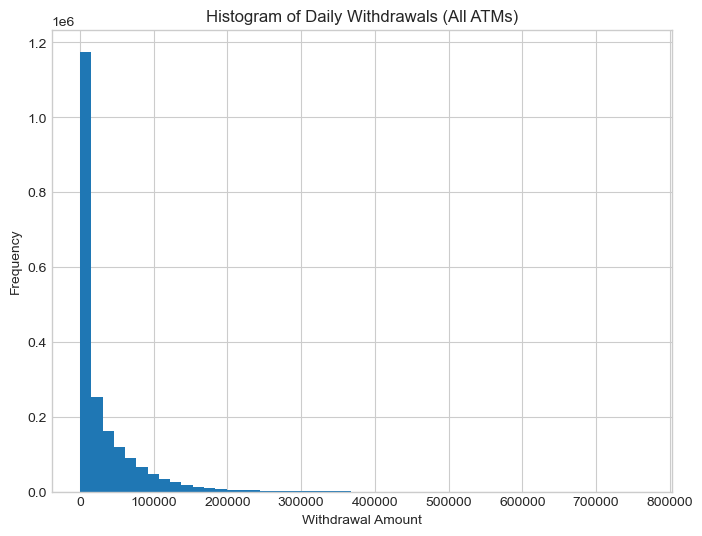

In [94]:
# Histogram of withdrawals
plt.figure(figsize=(8,6))
df_withdrawals["amount"].hist(bins=50)
plt.title("Histogram of Daily Withdrawals (All ATMs)")
plt.xlabel("Withdrawal Amount")
plt.ylabel("Frequency")
plt.savefig(r"M:\Credit Risk\CRF Data Analysis\Silvia Prep\ATM Modelling\figures\hist_withdrawals.png")

In [105]:
# Histogram of withdrawals
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Use the same underlying series as before (ensure identical filtering)
s = df_withdrawals["amount"].dropna()
s = s[s >= 0]  # keep non-negative amounts only

# Choose a bin width that yields enough detail within 0–30k
bin_width = 500          
bins = np.arange(0, 30000 + bin_width, bin_width)

plt.figure(figsize=(12,6))
sns.histplot(s, bins=bins, color="steelblue", edgecolor="black", stat="count")  # 'count' = frequency

# Titles & labels (fix unit)
plt.title("Histogram of Daily Withdrawal Amounts (All ATMs)", fontsize=14)
plt.xlabel("Withdrawal Amount (N$)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

plt.xlim(0, 30000)

# Ticks for readability
plt.xticks(np.arange(0, 30001, 5000), ['0', '5k', '10k', '15k', '20k', '25k', '30k'])

# Light grid and tight export
plt.grid(axis='y', alpha=0.25)
plt.tight_layout()
plt.savefig(r"M:\Credit Risk\CRF Data Analysis\Silvia Prep\ATM Modelling\figures\figure_5_1_hist_withdrawals_0_30k_consistent.png",
            dpi=300, bbox_inches='tight')
plt.close()


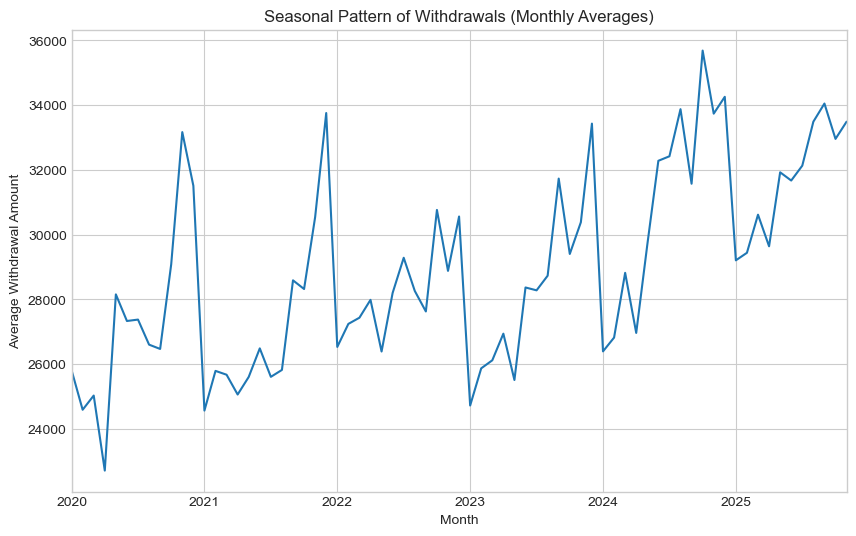

In [106]:
# Seasonal pattern
df_withdrawals["business_date"] = pd.to_datetime(df_withdrawals["business_date"])
df_withdrawals["month"] = df_withdrawals["business_date"].dt.to_period("M")
monthly_avg = df_withdrawals.groupby("month")["amount"].mean()

monthly_avg.plot(figsize=(10,6))
plt.title("Seasonal Pattern of Withdrawals (Monthly Averages)")
plt.ylabel("Average Withdrawal Amount")
plt.xlabel("Month")
plt.savefig(r"M:\Credit Risk\CRF Data Analysis\Silvia Prep\ATM Modelling\figures\figure_5_2_seasonal_withdrawals.png")

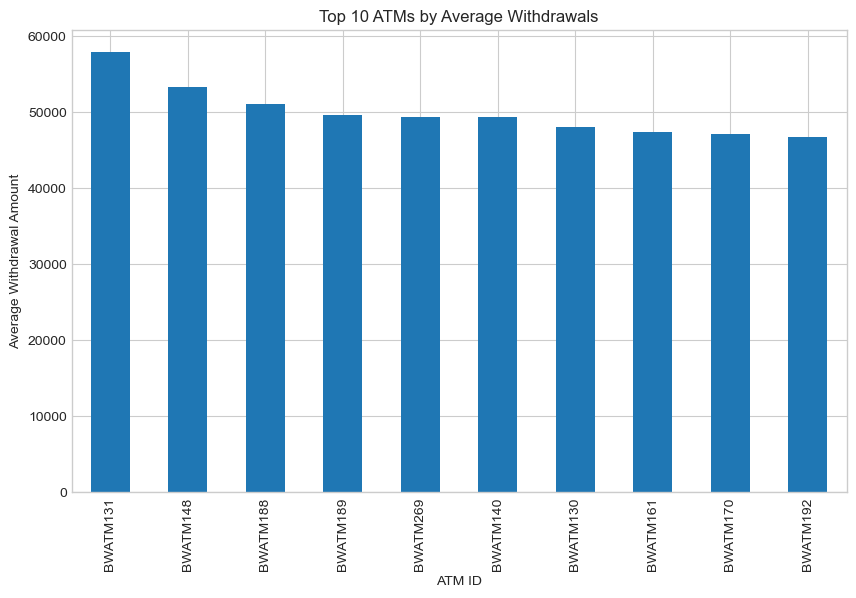

In [107]:
# Top 10 ATMs by average withdrawals
top10_atms = df_withdrawals.groupby("terminal_id")["amount"].mean().nlargest(10)
top10_atms.plot(kind="bar", figsize=(10,6))
plt.title("Top 10 ATMs by Average Withdrawals")
plt.ylabel("Average Withdrawal Amount")
plt.xlabel("ATM ID")
plt.savefig(r"M:\Credit Risk\CRF Data Analysis\Silvia Prep\ATM Modelling\figures\figure_5_3_top10_atms.png")

In [110]:
# --- Descriptive stats for downtime ---
stats_downtime = df_downtime["downtime_minutes"].describe(percentiles=[0.25, 0.5, 0.75])
stats_downtime.to_csv(r"M:\Credit Risk\CRF Data Analysis\Silvia Prep\ATM Modelling\tables\table_downtime_stats.csv")

In [121]:
# Downtime distribution
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Filter downtime values
s = df_downtime["downtime_minutes"].dropna()
s = s[s >= 0]

plt.figure(figsize=(10,6))
# Use finer bins for better detail (e.g., 50-minute intervals)
sns.histplot(s, bins=np.arange(0, 2001, 50), color="darkorange", edgecolor="black")

# Titles and labels
plt.title("Distribution of ATM Downtime (Minutes)", fontsize=14)
plt.xlabel("Downtime (minutes)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

# ✅ Adjust X-axis range to 0–2000
plt.xlim(0, 2000)
plt.xticks(np.arange(0, 2001, 250))

# Add grid for readability
plt.grid(axis='y', alpha=0.3)

# Save with tight bounding box
plt.tight_layout()
plt.savefig(r"M:\Credit Risk\CRF Data Analysis\Silvia Prep\ATM Modelling\figures\figure_downtime_distribution_0_2000.png",
            dpi=300, bbox_inches='tight')
plt.close()

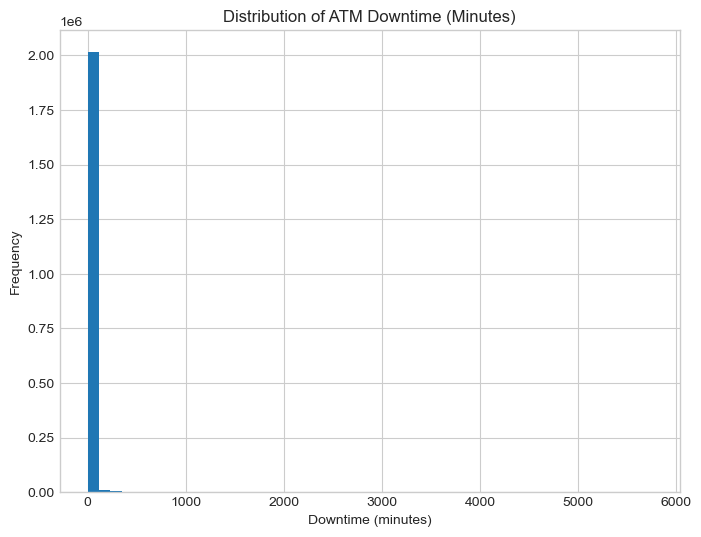

In [115]:
# Downtime distribution
plt.figure(figsize=(8,6))
df_downtime["downtime_minutes"].hist(bins=50)
plt.title("Distribution of ATM Downtime (Minutes)")
plt.xlabel("Downtime (minutes)")
plt.ylabel("Frequency")
plt.savefig(r"M:\Credit Risk\CRF Data Analysis\Silvia Prep\ATM Modelling\figures\figure_downtime_distribution.png")

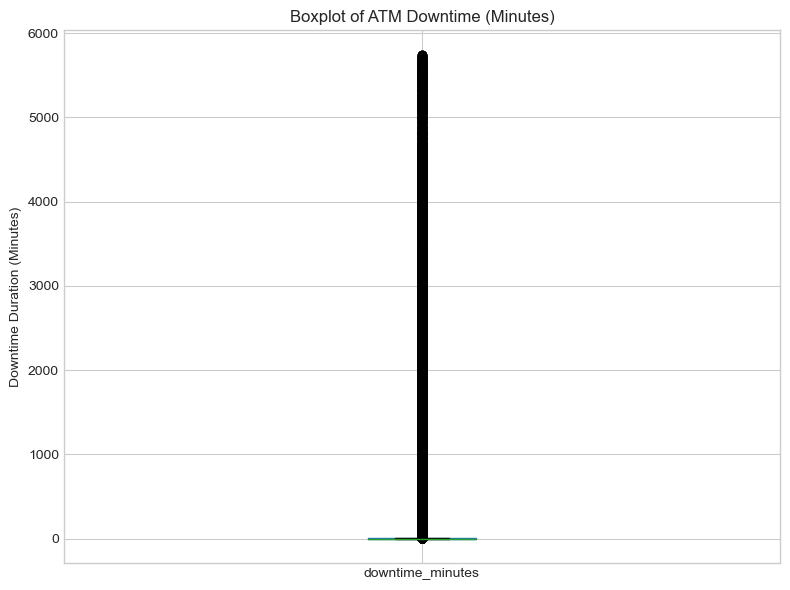

In [123]:
# Boxplot to show outliers clearly
plt.figure(figsize=(8,6))
df_downtime.boxplot(column="downtime_minutes")
plt.title("Boxplot of ATM Downtime (Minutes)")
plt.ylabel("Downtime Duration (Minutes)")
plt.tight_layout()
plt.savefig(r"M:\Credit Risk\CRF Data Analysis\Silvia Prep\ATM Modelling\figures\figure_5_4b_downtime_boxplot.png")
plt.show()

In [124]:
# Convert results list into DataFrame
results_df = pd.DataFrame(results)

# Save full results to your folder
results_df.to_csv(r"M:\Credit Risk\CRF Data Analysis\Silvia Prep\ATM Modelling\Table_All_Results.csv", index=False)

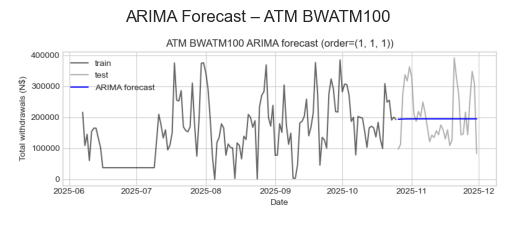

ARIMA results saved to:
 - Table_ARIMA_Performance_All.xlsx
 - Table_ARIMA_Best_Worst.xlsx
Example ARIMA chart saved to: M:\Credit Risk\CRF Data Analysis\Silvia Prep\ATM Modelling\Charts/arima_BWATM100.png


In [125]:
# Save ARIMA results (all ATMs)

charts_dir = Path(r"M:\Credit Risk\CRF Data Analysis\Silvia Prep\ATM Modelling\Charts")
charts_dir.mkdir(exist_ok=True)

arima_df = results_df[['ATM_ID','ARIMA_order','ARIMA_MAE','ARIMA_RMSE','ARIMA_MAPE']]
arima_df.to_excel("Table_ARIMA_Performance_All.xlsx", index=False)

# Top 5 best/worst ATMs by RMSE
arima_best5 = arima_df.nsmallest(5, "ARIMA_RMSE")
arima_worst5 = arima_df.nlargest(5, "ARIMA_RMSE")
pd.concat([arima_best5, arima_worst5]).to_excel("Table_ARIMA_Best_Worst.xlsx", index=False)

# Example of an ATM:
example_atm = "BWATM100"
plt.imshow(plt.imread(charts_dir / f"arima_{example_atm}.png"))
plt.axis("off")
plt.title(f"ARIMA Forecast – ATM {example_atm}")
plt.show()

print("ARIMA results saved to:")
print(" - Table_ARIMA_Performance_All.xlsx")
print(" - Table_ARIMA_Best_Worst.xlsx")
print(f"Example ARIMA chart saved to: {charts_dir}/arima_{example_atm}.png")

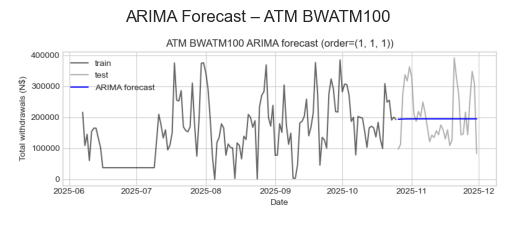

ARIMA results saved to:
 - M:\Credit Risk\CRF Data Analysis\Silvia Prep\ATM Modelling\Table_ARIMA_Performance_All.xlsx
 - M:\Credit Risk\CRF Data Analysis\Silvia Prep\ATM Modelling\Table_ARIMA_Best_Worst.xlsx


In [129]:
# ----------- SAVE ARIMA RESULTS -------------
# Convert results list to DataFrame
results_df = pd.DataFrame(results)

# Extract ARIMA-specific columns
arima_df = results_df[['ATM_ID', 'ARIMA_order', 'ARIMA_MAE', 'ARIMA_RMSE','ARIMA_MAPE']]

# Define output directory
output_path = Path(r"M:\Credit Risk\CRF Data Analysis\Silvia Prep\ATM Modelling")
output_path.mkdir(parents=True, exist_ok=True)

# Save full ARIMA performance table
arima_all_path = output_path / "Table_ARIMA_Performance_All.xlsx"
arima_df.to_excel(arima_all_path, index=False)

# Identify top 5 best and worst ATMs by RMSE
arima_best5 = arima_df.nsmallest(5, "ARIMA_RMSE")
arima_worst5 = arima_df.nlargest(5, "ARIMA_RMSE")
arima_best_worst_df = pd.concat([arima_best5, arima_worst5])

# Save best/worst ARIMA performance table
arima_best_worst_path = output_path / "Table_ARIMA_Best_Worst.xlsx"
arima_best_worst_df.to_excel(arima_best_worst_path, index=False)

# --------------------- DISPLAY EXAMPLE ARIMA CHART ---------------------
charts_dir = Path(r"M:\Credit Risk\CRF Data Analysis\Silvia Prep\ATM Modelling\charts")
example_atm = "BWATM100"
example_chart_path = charts_dir / f"arima_{example_atm}.png"

if example_chart_path.exists():
    img = plt.imread(example_chart_path)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"ARIMA Forecast – ATM {example_atm}")
    plt.show()
else:
    print(f"Example chart not found at {example_chart_path}")

# Confirm saved file paths
print("ARIMA results saved to:")
print(f" - {arima_all_path}")
print(f" - {arima_best_worst_path}")

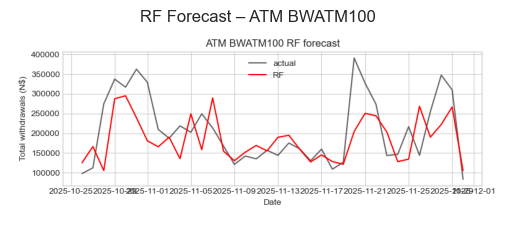

RF results saved to:
 - M:\Credit Risk\CRF Data Analysis\Silvia Prep\ATM Modelling\Table_RF_Performance_All.xlsx
 - M:\Credit Risk\CRF Data Analysis\Silvia Prep\ATM Modelling\Table_RF_Best_Worst.xlsx


In [131]:
# ----------- SAVE RF RESULTS -------------
# Convert results list to DataFrame
results_df = pd.DataFrame(results)

# Extract RF-specific columns
rf_df = results_df[['ATM_ID', 'RF_MAE', 'RF_RMSE','RF_MAPE']]

# Define output directory
output_path = Path(r"M:\Credit Risk\CRF Data Analysis\Silvia Prep\ATM Modelling")
output_path.mkdir(parents=True, exist_ok=True)

# Save full RF performance table
rf_all_path = output_path / "Table_RF_Performance_All.xlsx"
rf_df.to_excel(rf_all_path, index=False)

# Identify top 5 best and worst ATMs by RMSE
rf_best5 = rf_df.nsmallest(5, "RF_RMSE")
rf_worst5 = rf_df.nlargest(5, "RF_RMSE")
rf_best_worst_df = pd.concat([rf_best5, rf_worst5])

# Save best/worst RF performance table
rf_best_worst_path = output_path / "Table_RF_Best_Worst.xlsx"
rf_best_worst_df.to_excel(rf_best_worst_path, index=False)

# --------------------- DISPLAY EXAMPLE RF CHART ---------------------
charts_dir = Path(r"M:\Credit Risk\CRF Data Analysis\Silvia Prep\ATM Modelling\charts")
example_atm = "BWATM100"
example_chart_path = charts_dir / f"rf_{example_atm}.png"

if example_chart_path.exists():
    img = plt.imread(example_chart_path)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"RF Forecast – ATM {example_atm}")
    plt.show()
else:
    print(f"Example chart not found at {example_chart_path}")

# Confirm saved file paths
print("RF results saved to:")
print(f" - {rf_all_path}")
print(f" - {rf_best_worst_path}")

In [133]:
# ----------- SAVE HW RESULTS -------------
# Convert results list to DataFrame
results_df = pd.DataFrame(results)

# Extract HW-specific columns
hw_df = results_df[['ATM_ID', 'HW_MAE', 'HW_RMSE','HW_MAPE']]

# Define output directory
output_path = Path(r"M:\Credit Risk\CRF Data Analysis\Silvia Prep\ATM Modelling")
output_path.mkdir(parents=True, exist_ok=True)

# Save full HW performance table
hw_all_path = output_path / "Table_HW_Performance_All.xlsx"
hw_df.to_excel(hw_all_path, index=False)

# Identify top 5 best and worst ATMs by RMSE
hw_best5 = hw_df.nsmallest(5, "HW_RMSE")
hw_worst5 = hw_df.nlargest(5, "HW_RMSE")
hw_best_worst_df = pd.concat([hw_best5, hw_worst5])

# Save best/worst HW performance table
hw_best_worst_path = output_path / "Table_HW_Best_Worst.xlsx"
hw_best_worst_df.to_excel(hw_best_worst_path, index=False)

# --------------------- DISPLAY EXAMPLE RF CHART ---------------------
charts_dir = Path(r"M:\Credit Risk\CRF Data Analysis\Silvia Prep\ATM Modelling\charts")
example_atm = "BWATM100"
example_chart_path = charts_dir / f"hw_{example_atm}.png"

if example_chart_path.exists():
    img = plt.imread(example_chart_path)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"HW Forecast – ATM {example_atm}")
    plt.show()
else:
    print(f"Example chart not found at {example_chart_path}")

# Confirm saved file paths
print("HW results saved to:")
print(f" - {hw_all_path}")
print(f" - {hw_best_worst_path}")

Example chart not found at M:\Credit Risk\CRF Data Analysis\Silvia Prep\ATM Modelling\charts\hw_BWATM100.png
HW results saved to:
 - M:\Credit Risk\CRF Data Analysis\Silvia Prep\ATM Modelling\Table_HW_Performance_All.xlsx
 - M:\Credit Risk\CRF Data Analysis\Silvia Prep\ATM Modelling\Table_HW_Best_Worst.xlsx


In [135]:
print(results_df.columns)

Index(['ATM_ID', 'N_days', 'ARIMA_order', 'ARIMA_MAE', 'ARIMA_RMSE',
       'ARIMA_MAPE', 'HW_MAE', 'HW_RMSE', 'HW_MAPE', 'RF_MAE', 'RF_RMSE',
       'RF_MAPE', 'Best_Model'],
      dtype='object')


In [137]:
# ------------------ GRAPH SHOWS DAYS INSTEAD OF NUMBERS -----------
# Map day_of_week (0=Mon) to names
day_names = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}

fig2 = df_daily.groupby('day_of_week')['total_withdrawals'].mean()
fig2.index = fig2.index.map(day_names)

fig2.plot(kind='bar', color='steelblue', title='Average Withdrawals by Day of Week')
plt.ylabel('Average Withdrawals (NAD)')
plt.xlabel('Day of Week')
plt.savefig(output_path / 'Avg_By_DayOfWeek.png', dpi=300)
plt.close()

In [139]:
# ------------------- FIGURE: Avg Withdrawals by Region & Location -------------------
fig3 = df_daily.groupby(['Region','ATM_Location_Type'])['total_withdrawals'].mean().unstack()
fig3.plot(kind='bar', figsize=(10,6), title='Average Withdrawals by Region and Location Type')
plt.ylabel('Average Withdrawals (NAD)')
plt.savefig(output_path / 'Avg_By_Region_Location.png', dpi=300)
plt.close()

In [141]:
# ------------------- FIGURE: Top 10 Towns -------------------
fig4 = df_daily.groupby('ATM_Town')['total_withdrawals'].sum().nlargest(10)
fig4.plot(kind='bar', color='darkgreen', title='Top 10 Towns by Total Withdrawals')
plt.ylabel('Total Withdrawals (NAD)')
plt.savefig(output_path / 'Top10_Towns.png', dpi=300)
plt.close()

In [143]:
# ------------------- FIGURE: Downtime vs Withdrawals Scatter -------------------
plt.scatter(df_daily['downtime_minutes'], df_daily['total_withdrawals'], alpha=0.3)
plt.title('Relationship Between Downtime and Withdrawals')
plt.xlabel('Downtime (minutes)')
plt.ylabel('Withdrawals (NAD)')
plt.savefig(output_path / 'Downtime_vs_Withdrawals.png', dpi=300)
plt.close()

In [144]:
# ------------------- FIGURE: Boxplot of MAE and RMSE -------------------
plt.figure(figsize=(8,5))
results_df[['ARIMA_MAE','RF_MAE','HW_MAE']].plot(kind='box')
plt.title('Model Performance Comparison (MAE)')
plt.savefig(output_path / 'Boxplot_MAE.png', dpi=300)
plt.close()

plt.figure(figsize=(8,5))
results_df[['ARIMA_RMSE','RF_RMSE','HW_RMSE']].plot(kind='box')
plt.title('Model Performance Comparison (RMSE)')
plt.savefig(output_path / 'Boxplot_RMSE.png', dpi=300)
plt.close()

plt.figure(figsize=(8,5))
results_df[['ARIMA_MAPE','RF_MAPE','HW_MAPE']].plot(kind='box')
plt.title('Model Performance Comparison (MAPE)')
plt.savefig(output_path / 'Boxplot_MAPE.png', dpi=300)
plt.close()

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

In [145]:
# ------------------- TABLE: Summary Stats -------------------
summary_stats = df_daily['total_withdrawals'].describe()
summary_stats.to_excel(output_path / 'Summary_Stats.xlsx')

In [146]:
# ------------------- TABLE: Stats by Day of Week -------------------
dow_stats = df_daily.groupby('day_of_week')['total_withdrawals'].describe()
dow_stats.to_excel(output_path / 'By_DayOfWeek.xlsx')

In [147]:
# ------------------- TABLE: Withdrawals by Region & Location -------------------
region_stats = df_daily.groupby(['Region','ATM_Location_Type'])['total_withdrawals'].sum()
region_stats.to_excel(output_path / 'By_Region_Location.xlsx')

In [149]:
# ------------------- TABLE: Correlation -------------------
corr_matrix = df_daily[['total_withdrawals','downtime_minutes']].corr()
corr_matrix.to_excel(output_path / 'Correlation.xlsx')

In [155]:
# ------------------- TABLE: Avg MAE/RMSE/MAPE -------------------
avg_metrics = {
    'ARIMA_MAE': results_df['ARIMA_MAE'].mean(),
    'ARIMA_RMSE': results_df['ARIMA_RMSE'].mean(),
    'ARIMA_MAPE': results_df['ARIMA_MAPE'].mean(),
    'RF_MAE': results_df['RF_MAE'].mean(),
    'RF_RMSE': results_df['RF_RMSE'].mean(),
    'RF_MAPE': results_df['RF_MAPE'].mean(),
    'HW_MAE': results_df['HW_MAE'].mean(),
    'HW_RMSE': results_df['HW_RMSE'].mean(),
    'HW_MAPE': results_df['HW_MAPE'].mean()
}
pd.DataFrame([avg_metrics]).to_excel(output_path / 'Model_Comparison.xlsx')